## **Data Preprocessing**

### Import the data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/Final Dataset/final.pkl', 'rb') as f:
  target_texts = pickle.load(f)

### Remove diacritics

In [ ]:
import unicodedata

REMOVE_DIACRITIC_TABLE = str.maketrans(
    "ÁÀẢÃẠĂẮẰẲẴẶÂẤẦẨẪẬĐÈÉẺẼẸÊẾỀỂỄỆÍÌỈĨỊÓÒỎÕỌÔỐỒỔỖỘƠỚỜỞỠỢÚÙỦŨỤƯỨỪỬỮỰÝỲỶỸỴáàảãạăắằẳẵặâấầẩẫậđèéẻẽẹêếềểễệíìỉĩịóòỏõọôốồổỗộơớờởỡợúùủũụưứừửữựýỳỷỹỵ",
    "A" * 17 + "D" + "E" * 11 + "I" * 5 + "O" * 17 + "U" * 11 + "Y" * 5 + "a" * 17 + "d" + "e" * 11 + "i" * 5 + "o" * 17 + "u" * 11 + "y" * 5
)


def remove_diacritic(txt: str) -> str:
    if not unicodedata.is_normalized("NFC", txt):
        txt = unicodedata.normalize("NFC", txt)
    return txt.translate(REMOVE_DIACRITIC_TABLE)

print(remove_diacritic("Đà Nẵng?").lower())

da nang?


In [ ]:
input_texts = [remove_diacritic(sentence) for sentence in target_texts]

In [ ]:
# Lower the text from input and output
input_temp = []
target_temp = []
for index in range(len(input_texts)):
  if len(input_texts[index].split()) < 200:
    input_temp.append(input_texts[index])
    target_temp.append(target_texts[index])

input_texts = input_temp
target_texts = target_temp

### Tokenize

In [ ]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [ ]:
# Tokenize the inputs
MAX_NUM_WORDS = 22300
tokenizer_input = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_input.fit_on_texts(input_texts)
input_sequences = tokenizer_input.texts_to_sequences(input_texts)

### Get the mapping from input-to-index and padding sequences

In [ ]:
# Get the word to index mapping for input
word2idx_input = tokenizer_input.word_index
print('Found %s unique tokens.' % len(word2idx_input))

Found 22216 unique tokens.


In [ ]:
# determine max length input sequence
max_len_input = max(len(s) for s in input_sequences)
print('Max input length:', max_len_input)

Max input length: 199


In [ ]:
# pad the sequences to NxT matrix
input_sequences = pad_sequences(input_sequences, maxlen=max_len_input, padding='post', value=0)
print('Shape of input tensor:', input_sequences.shape)
# [1, 2, 1, 3, 0, 0] max_len_input = 6

Shape of input tensor: (299988, 199)


In [ ]:
# Create a mapping from targets to target labels
import re
def remove_punctuation(text: str) -> str:
    return re.sub(r'[^\w\s]', '', text)

In [ ]:
target_texts = [remove_punctuation(txt) for txt in target_texts]

In [ ]:
print(len(input_texts))
print(len(target_texts))

299988
299988


### Word to Index Dictionary

In [ ]:
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/all-vietnamese-syllables.txt', 'r', encoding='utf-8') as f:
  all_syllables = f.read().split('\n')

In [ ]:
word2idx = {}
for text in target_texts:
  data = text.split(' ')
  for word in data:
    remove_diacritic_word = remove_diacritic(word)
    if remove_diacritic_word not in word2idx:
      word2idx[remove_diacritic_word] = {word: 1}
    else:
      if word not in word2idx[remove_diacritic_word]:
        word2idx[remove_diacritic_word][word] = len(word2idx[remove_diacritic_word]) + 1

In [ ]:
for word in all_syllables:
  remove_diacritic_word = remove_diacritic(word)
  if remove_diacritic_word not in word2idx:
    word2idx[remove_diacritic_word] = {word: 1}
  else:
    if word not in word2idx[remove_diacritic_word]:
      word2idx[remove_diacritic_word][word] = len(word2idx[remove_diacritic_word]) + 1

In [ ]:
len(word2idx)

23955

### Padding the target sequences

In [ ]:
target_labels = []
for text in target_texts:
  label = []
  data = text.split(' ')
  for word in data:
    remove_diacritic_word = remove_diacritic(word)
    label.append(word2idx[remove_diacritic_word][word])
  target_labels.append(label)

In [ ]:
target_labels = pad_sequences(target_labels, maxlen=max_len_input, padding='post', value=0)
print('Shape of target tensor:', target_labels.shape)

Shape of target tensor: (299988, 199)


In [ ]:
num_labels = max(max(label) for label in target_labels) + 1

In [ ]:
num_labels

30

### Create an index-to-word Dictionary

In [ ]:
idx2word = {}
for key in word2idx.keys():
  idx2word[key] = {}
  for word in word2idx[key].keys():
    idx2word[key][word2idx[key][word]] = word

## **Deploy the model**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras

In [ ]:
num_words = min(MAX_NUM_WORDS, len(word2idx_input) + 1)

### Positional Encoding

In [ ]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [ ]:
@keras.saving.register_keras_serializable()
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length=2048, depth=d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

### Base Attention Layer

In [ ]:
import keras

In [ ]:
@keras.saving.register_keras_serializable()
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-7)
    self.add = tf.keras.layers.Add()

In [ ]:
# Global attention layer
@keras.saving.register_keras_serializable()
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    attn_output = self.mha(
        query=x,
        value=x,
        key=x)
    x = self.add([x, attn_output])
    x = self.layernorm(x)
    return x


### FeedForward Network

In [ ]:
@keras.saving.register_keras_serializable()
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, d_model, dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),
      tf.keras.layers.Dense(d_model),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-7)

  def call(self, x):
    x = self.add([x, self.seq(x)])
    x = self.layer_norm(x)
    return x

### Encoder Layer

In [ ]:
@keras.saving.register_keras_serializable()
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForward(d_model, dff)

  def call(self, x):
    x = self.self_attention(x)
    x = self.ffn(x)
    return x

### **Encoder**

In [ ]:
@keras.saving.register_keras_serializable()
class Encoder(tf.keras.layers.Layer):
  def __init__(self, *, num_layers, d_model, num_heads,
               dff, vocab_size, dropout_rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.pos_embedding = PositionalEmbedding(
        vocab_size=vocab_size, d_model=d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model,
                     num_heads=num_heads,
                     dff=dff,
                     dropout_rate=dropout_rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(dropout_rate)

  def call(self, x):
    # `x` is token-IDs shape: (batch, seq_len)
    x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

    # Add dropout.
    x = self.dropout(x)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x)

    return x  # Shape `(batch_size, seq_len, d_model)`.

## **Get the model**

In [ ]:
from keras import Model, Input
from keras.layers import Dense, TimeDistributed

In [ ]:
EMBEDDING_DIM = 200
NUM_LAYERS = 4
VOCAB_SIZE = len(word2idx_input)
NUM_HEADS = 8
MAX_LENGTH_INPUT = max_len_input

In [ ]:
# Instantiate the encoder.
encoder = Encoder(num_layers=NUM_LAYERS,
                  d_model=EMBEDDING_DIM,
                  num_heads=NUM_HEADS,
                  dff=MAX_LENGTH_INPUT,
                  vocab_size=VOCAB_SIZE)

In [ ]:
input = Input(shape=(max_len_input,))
x = encoder(input)
out = TimeDistributed(Dense(num_labels, activation="softmax"))(x)
model = Model(input, out)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 199)]             0         
                                                                 
 encoder_1 (Encoder)         (None, 199, 200)          9906396   
                                                                 
 time_distributed_1 (TimeDi  (None, 199, 30)           6030      
 stributed)                                                      
                                                                 
Total params: 9912426 (37.81 MB)
Trainable params: 9912426 (37.81 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## **Train the model**

In [ ]:
import keras.backend as K

In [ ]:
BATCH_SIZE = 128
EPOCHS = 10
VALIDATION_SPLIT = 0.2

In [ ]:
@keras.saving.register_keras_serializable()
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

  def get_config(self):
    return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

In [ ]:
learning_rate = CustomSchedule(d_model=EMBEDDING_DIM)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

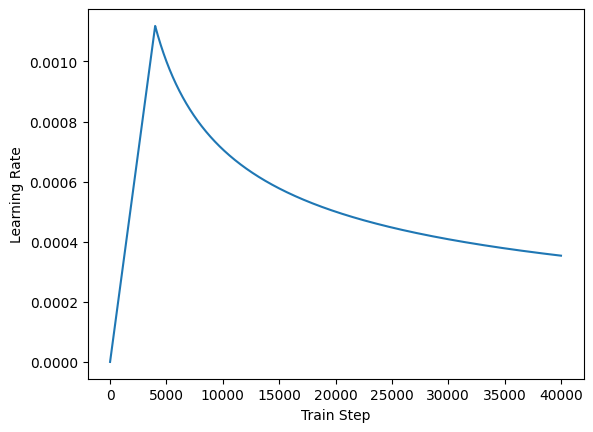

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [ ]:
def acc(y_true, y_pred):
    # both are of shape N x T x K
    targ = K.cast(y_true, dtype='int64')
    pred = K.argmax(y_pred, axis=-1)
    correct = K.cast(K.equal(targ, pred), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(targ, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
    return n_correct / n_total

In [ ]:
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=[acc]
              )

In [ ]:
print('Training model...')
r = model.fit(
    input_sequences,
    target_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=VALIDATION_SPLIT,
)

Training model...
Epoch 1/10
1875/1875 [==============================] - 299s 152ms/step - loss: 0.9597 - acc: 0.6869 - val_loss: 0.6693 - val_acc: 0.7900
Epoch 2/10
1875/1875 [==============================] - 276s 147ms/step - loss: 0.6677 - acc: 0.7883 - val_loss: 0.5209 - val_acc: 0.8530
Epoch 3/10
1875/1875 [==============================] - 275s 147ms/step - loss: 0.5769 - acc: 0.8220 - val_loss: 0.4662 - val_acc: 0.8751
Epoch 4/10
1875/1875 [==============================] - 274s 146ms/step - loss: 0.5208 - acc: 0.8402 - val_loss: 0.4376 - val_acc: 0.8857
Epoch 5/10
1875/1875 [==============================] - 275s 146ms/step - loss: 0.4851 - acc: 0.8512 - val_loss: 0.4232 - val_acc: 0.8914
Epoch 6/10
1875/1875 [==============================] - 274s 146ms/step - loss: 0.4597 - acc: 0.8589 - val_loss: 0.4045 - val_acc: 0.8963
Epoch 7/10
1875/1875 [==============================] - 274s 146ms/step - loss: 0.4396 - acc: 0.8645 - val_loss: 0.4056 - val_acc: 0.8984
Epoch 8/10
1875/

In [ ]:
import matplotlib.pyplot as plt

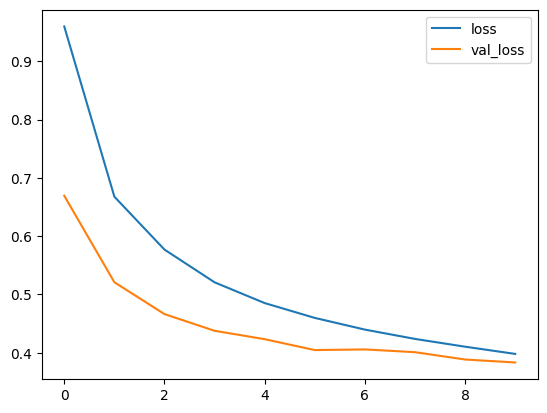

In [ ]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

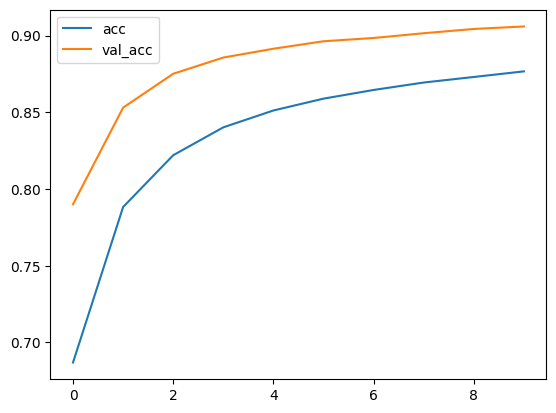

In [ ]:
# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

## **Prediction Phase**

In [ ]:
import numpy as np

In [ ]:
def convert_text_to_sequences(text):
  text_sequences = tokenizer_input.texts_to_sequences(text)
  text_sequences = pad_sequences(text_sequences, maxlen=max_len_input, padding='post', value=0)
  return text_sequences

In [ ]:
def get_prediction(list_of_queries: list):
  text_queries = convert_text_to_sequences(list_of_queries)
  p = model.predict(text_queries)
  p = np.argmax(p, axis=-1)
  predict_output = []
  for query in list_of_queries:
     user_query_split = remove_punctuation(query).lower().split(" ")
     predict_output_temp = ""
     for t in range(len(user_query_split)):
       if user_query_split[t] not in idx2word.keys() or p[0][t] not in idx2word[user_query_split[t]].keys():
         predict_output_temp += user_query_split[t] + " "
       else:
        predict_output_temp += str(idx2word[user_query_split[t]][p[0][t]]) + " "
     predict_output.append(predict_output_temp)
  return predict_output

In [ ]:
user_query = [input_texts[3000]]

In [ ]:
print(get_prediction(user_query))
print(target_texts[3000])

1/1 [==============================] - 1s 718ms/step
['sử hấp dẫn có liên quan mật thiết đến điều chúng ta luôn khao khát là yếu và được yêu ']
Sự hấp dẫn có liên quan mật thiết đến điều chúng ta luôn khao khát là yêu và được yêu


In [ ]:
print(get_prediction(["Hom nay troi dep, troi trong xanh bao la"]))

1/1 [==============================] - 0s 27ms/step
['hôm nay trời đẹp trời trong xanh bao lá ']


## **Test Phase**

In [ ]:
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/test_X_250k.pkl', 'rb') as f:
  input_test_texts = pkl.load(f)
with open('/content/drive/MyDrive/Datasets/Vietnamese Diacritics Restoration/test_Y_250k.pkl', 'rb') as f:
  target_test_texts = pkl.load(f)

In [ ]:
indexes = [i for i in range(100)]

In [ ]:
for index in indexes:
  print("Predict: " + get_prediction([input_test_texts[index]])[0])
  print("Actual: " + target_test_texts[index])

In [ ]:
word2idx['lam']

## **Save and Load the Model**

In [ ]:
import json
import pickle

In [ ]:
# Convert and write JSON object to file
with open("word2idx_final.json", "w") as outfile:
    json.dump(word2idx, outfile)

In [ ]:
with open("idx2word_final.json", "w") as outfile:
    json.dump(idx2word, outfile)

In [ ]:
# save the model to disk
filename = 'tokenizer_final.pkl'
pickle.dump(tokenizer_input, open(filename, 'wb'))

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("transformer_final.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
# serialize weights to HDF5
model.save_weights("transformer_weights_final.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('transformer_final.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [ ]:
loaded_model = keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("transformer_weights_final.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
loaded_model.predict(convert_text_to_sequences(["Hom nay troi dep, troi trong xanh bao la"]))

1/1 [==============================] - 1s 675ms/step


array([[[3.2600386e-05, 9.9726188e-01, 2.0768156e-03, ...,
         6.6152249e-13, 5.0353824e-13, 7.0357614e-13],
        [2.1124697e-05, 7.1331598e-02, 9.2724770e-01, ...,
         2.2138655e-13, 1.4318512e-13, 1.5807486e-13],
        [2.0959931e-05, 2.2240035e-02, 9.6477139e-01, ...,
         4.9142309e-13, 5.2415781e-13, 2.9178285e-13],
        ...,
        [5.3481786e-03, 5.1988363e-01, 1.7900847e-01, ...,
         1.1436952e-10, 8.7218427e-11, 9.2016179e-11],
        [5.4365126e-03, 5.1114190e-01, 1.8612042e-01, ...,
         1.1773477e-10, 9.0931533e-11, 9.3729836e-11],
        [5.6268279e-03, 4.9696922e-01, 1.9313058e-01, ...,
         1.2520507e-10, 9.7573442e-11, 9.8327090e-11]]], dtype=float32)

In [ ]:
def get_prediction(list_of_queries: list):
  text_queries = convert_text_to_sequences(list_of_queries)
  p = loaded_model.predict(text_queries)
  print(p)
  p = np.argmax(p, axis=-1)
  print(p)
  predict_output = []
  for query in list_of_queries:
     user_query_split = remove_punctuation(query).lower().split(" ")
     predict_output_temp = ""
     for t in range(len(user_query_split)):
       if user_query_split[t] not in idx2word.keys() or p[0][t] not in idx2word[user_query_split[t]].keys():
         predict_output_temp += user_query_split[t] + " "
       else:
        predict_output_temp += str(idx2word[user_query_split[t]][p[0][t]]) + " "
     predict_output.append(predict_output_temp)
  return predict_output

In [ ]:
get_prediction(["Hom nay troi that dep"])

1/1 [==============================] - 0s 27ms/step
[[[1.03737322e-04 9.97484803e-01 1.58440752e-03 ... 1.60007077e-12
   1.26756721e-12 1.45137559e-12]
  [5.10607679e-05 1.31487876e-01 8.66103113e-01 ... 3.01327160e-13
   2.87010053e-13 1.76253042e-13]
  [5.42885864e-05 4.04138640e-02 7.88595259e-01 ... 1.51749858e-12
   2.35265323e-12 8.05075570e-13]
  ...
  [5.79713611e-03 5.26587367e-01 1.74247295e-01 ... 1.22153759e-10
   9.43643150e-11 9.85393434e-11]
  [5.89606725e-03 5.17258644e-01 1.81665346e-01 ... 1.26994804e-10
   9.94748103e-11 1.01390923e-10]
  [6.09977776e-03 5.03140509e-01 1.88965648e-01 ... 1.34767988e-10
   1.06423134e-10 1.06055956e-10]]]
[[1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

['hôm nay trời thật đẹp ']

In [ ]:
get_prediction(["Em da hoc rat nhieu thay co giao nhung trong do thay Khoat la giao vien em thay tam dac nhat"])

1/1 [==============================] - 0s 27ms/step
[[[3.1610718e-05 9.9758005e-01 1.6745679e-03 ... 6.8019424e-13
   5.6874866e-13 6.4451472e-13]
  [2.8930170e-05 9.9689662e-01 6.5411406e-04 ... 4.9598997e-12
   3.3817059e-12 5.1701755e-12]
  [2.7142620e-05 9.9722654e-01 5.5221486e-04 ... 1.8952782e-12
   1.4028342e-12 3.1868353e-12]
  ...
  [3.7637244e-03 5.6882352e-01 1.7531303e-01 ... 6.5628891e-11
   5.0649502e-11 5.4138284e-11]
  [3.8734344e-03 5.5896795e-01 1.8220289e-01 ... 6.8556931e-11
   5.3605665e-11 5.5798300e-11]
  [4.0659807e-03 5.3708202e-01 1.9473386e-01 ... 7.6321109e-11
   6.0290273e-11 6.1239125e-11]]]
[[1 1 1 1 1 6 9 2 2 2 1 6 1 1 2 1 1 2 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
  1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1


['em đã học rất nhiều thày cô giáo nhưng trong đó thày khoát là giáo viên em thấy tâm đắc nhất ']

In [ ]:
idx2word['that']

{1: 'thật',
 2: 'thất',
 3: 'thắt',
 4: 'thât',
 5: 'that',
 6: 'thát',
 7: 'thạt',
 8: 'thẳt',
 9: 'thặt'}

In [ ]:
loaded_model.get_weights()

[array([[ 0.0437049 , -0.01176592, -0.03185474, ..., -0.02460885,
          0.03353084,  0.00343724],
        [-0.00162965, -0.00590599, -0.00292508, ..., -0.15636227,
         -0.08754724, -0.17681251],
        [ 0.00240576, -0.00491627, -0.0050069 , ..., -0.2054604 ,
         -0.2324423 , -0.11534539],
        ...,
        [-0.04970609,  0.00844957, -0.03613013, ..., -0.00775222,
          0.00236349,  0.01808733],
        [ 0.03280928,  0.00603376,  0.00709432, ..., -0.03876013,
          0.00835248,  0.04446958],
        [-0.04795448, -0.01529902, -0.02669995, ...,  0.04912913,
          0.01944187,  0.03879279]], dtype=float32),
 array([[[ 1.30537942e-01, -3.39084603e-02, -1.39644057e-01, ...,
           2.74231911e-01, -2.85255939e-01, -3.99737768e-02],
         [ 1.22225069e-01, -8.97905305e-02, -4.84136790e-02, ...,
           1.09511067e-03, -8.57673213e-02,  2.47048493e-02],
         [-8.43146086e-01, -3.04803438e-02, -1.31033286e-01, ...,
          -1.37372935e+00, -4.717919